## Importing the libraries

In [67]:
import io # Input output operations
import os # Operating system
import shutil # TO perform high level file operations
import string # to perform high level string operations
import re # Regular expression

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Downloding the dataset

You will use the Large Movie Review Dataset through the tutorial. You will train a sentiment classifier model on this dataset and in the process learn embeddings from scratch.

In [68]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, 
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'README', 'test']

Take a look at the train/ directory. It has pos and neg folders with movie reviews labelled as positive and negative respectively. You will use reviews from pos and neg folders to train a binary classification model.

In [69]:
# train dataset directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'neg',
 'unsup',
 'urls_unsup.txt',
 'unsupBow.feat']

#### train directory also has additioinal folders which should be removed before creating dataset

In [70]:
remove_dir = os.path.join(train_dir, 'unsup')

shutil.rmtree(remove_dir)


Next, create a tf.data.Dataset using tf.keras.preprocessing.text_dataset_from_directory.

Use the train directory to create both train and validation datasets with a split of 20% for validation.



In [71]:
batch_size = 1024
seed = 123

train_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size, validation_split=0.2, 
    subset='training', seed=seed
)

validation_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size, validation_split=0.2, 
    subset='validation', seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Take a look at a few movie reviews and their labels (1: positive, 0: negative) from the train dataset.



In [72]:
for text, label in train_dataset.take(1):
  for i in range(5):
    print(label[i].numpy(), text.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

## Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training. 

In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Using the Embedding layer

Keras makes it easy to use word embeddings.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [74]:
# Embeded 1000 words into 5 dimesion
embedding_layer = tf.keras.layers.Embedding(1000, 5)


When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

In [75]:
# If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()


array([[ 0.01419505, -0.03039126,  0.00285299,  0.01637185, -0.00406059],
       [-0.01751189,  0.04935582,  0.0127713 ,  0.00139158,  0.03109893],
       [-0.01356477,  0.04451648, -0.03404649,  0.0295887 , -0.04784168]],
      dtype=float32)

## Text preprocessing
Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews.

In [76]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standarization(imput_data):
  lowercase = tf.strings.lower(imput_data)
  break_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(break_html, 
                                  '[%s]' % re.escape(string.punctuation), '')

In [77]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standarization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [78]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_dataset = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_dataset)

## Create a classification model

In [79]:
embedding_dims = 16
model = Sequential([
                    vectorize_layer,
                    Embedding(vocab_size, embedding_dims, name='embedding'),
                    GlobalAveragePooling1D(),
                    Dense(16, activation='tanh'),
                    tf.keras.layers.Dropout(0.5),
                    Dense(16, activation='tanh'),
                    tf.keras.layers.Dropout(0.5),
                    Dense(1)
]
)

## Compile and Train model

In [80]:
# Using tenorbord
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


Compile and train the model using the Adam optimizer and BinaryCrossentropy loss. 

In [81]:
model.compile(optimizer='adamax',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[tensorboard_callback]
)

Epoch 1/30
20/20 [==============================] - 4s 169ms/step - loss: 0.6930 - accuracy: 0.5037 - val_loss: 0.6923 - val_accuracy: 0.4886
Epoch 2/30
20/20 [==============================] - 1s 75ms/step - loss: 0.6916 - accuracy: 0.5037 - val_loss: 0.6907 - val_accuracy: 0.4886
Epoch 3/30
20/20 [==============================] - 1s 76ms/step - loss: 0.6899 - accuracy: 0.5037 - val_loss: 0.6882 - val_accuracy: 0.4886
Epoch 4/30
20/20 [==============================] - 2s 77ms/step - loss: 0.6872 - accuracy: 0.5037 - val_loss: 0.6840 - val_accuracy: 0.4886
Epoch 5/30
20/20 [==============================] - 1s 75ms/step - loss: 0.6827 - accuracy: 0.5037 - val_loss: 0.6777 - val_accuracy: 0.4886
Epoch 6/30
20/20 [==============================] - 2s 76ms/step - loss: 0.6749 - accuracy: 0.5041 - val_loss: 0.6684 - val_accuracy: 0.4886
Epoch 7/30
20/20 [==============================] - 2s 78ms/step - loss: 0.6654 - accuracy: 0.5056 - val_loss: 0.6559 - val_accuracy: 0.4886
Epoch 8/30
2

With this approach the model reaches a validation accuracy of around 84% (note that the model is overfitting since training accuracy is higher).

In [83]:
# observing the summery
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)               

Visualize the model metrics in TensorBoard.

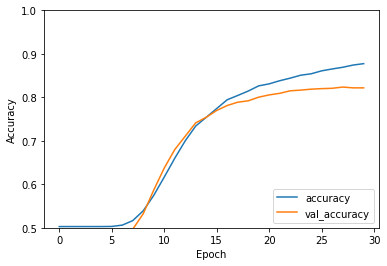

In [84]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [85]:
dataset = [['This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without all the annoying songs). The songs that are sung are likable; you might even find yourself singing these songs once the movie is through. This musical ranks number two in musicals to me (second next to the blues brothers). But please, do not think of it as a musical per say; seeing as how the songs are so likable, it is hard to tell a carefully choreographed scene is taking place. I think of this movie as more of a comedy with undertones of romance. You will be reminded of what it was like to be a rebellious teenager; needless to say, you will be reminiscing of your old high school days after seeing this film. Highly recommended for both the family (since it is a very youthful but also for adults since there are many jokes that are funnier with age and experience.']]
predict = model.predict(dataset)

if predict[0] > 0.5:
  print('yes')
else:
  print('NO')

yes


## Save and load model


In [86]:
export_model = 'imdb_saved_model'
tf.saved_model.save(model, export_model)

INFO:tensorflow:Assets written to: imdb_saved_model/assets


In [88]:
reloded = tf.saved_model.load(export_model)
reloded_result = reloded(dataset, training=False)

In [89]:
if reloded_result[0] > 0.5:
  print('yes')
else:
  print('NO')

yes


## Retrieve the trained word embeddings and save them to disk

Next, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape (vocab_size, embedding_dimension).

Obtain the weights from the model using get_layer() and get_weights(). The get_vocabulary() function provides the vocabulary to build a metadata file with one token per line. 

In [90]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

Write the weights to disk. To use the Embedding Projector, you will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).



In [91]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [92]:
# try:
  #from google.colab import files
  #files.download('vectors.tsv')
  #files.download('metadata.tsv')
# except Exception:
  #pass
